# Training of the flow matching model

In this script we will train the flow matching model.
For this purpose we will use the training data already encoded in a 50 dimension space.

- Loading libraries

In [16]:
#from abc import ABC, abstractmethod
from typing import Optional #, List, Type, Tuple, Dict
import math
import anndata as ad
#import numpy as np
from matplotlib import pyplot as plt
#import matplotlib.cm as cm
#from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
#from torch.func import vmap, jacrev
#from tqdm import tqdm
#import seaborn as sns
#from sklearn.datasets import make_moons, make_circles
import torch.nn.functional as F
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- Loading data

In [2]:
# Load the encoded data from the autoencoder
data_dir = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/"
input_file_path = data_dir + "pbmc3k_train_with_latent.h5ad"
adata = ad.read_h5ad(input_file_path)

# Access latent representation
latent = adata.obsm["X_latent"]
# make it to a tensor and save in GPU
latent_tensor = torch.tensor(latent, dtype=torch.float32, device = device)
print("Shape of latent space:", latent.shape)
print(latent)

Shape of latent space: (2110, 50)
[[-1.4144031   1.3279299   0.757624   ...  1.9632016   3.2006185
   1.0286264 ]
 [-3.0197775  -1.5338613   1.2328798  ... -1.762154    3.0394304
  -0.13480194]
 [-2.9895246  -0.5492041   0.01084488 ...  1.2618108  -1.4493724
   0.35208455]
 ...
 [ 1.2099221   0.04875063 -0.70176685 ...  1.5337447   1.6093717
  -0.77522033]
 [ 0.16601333  0.13243417  1.3788003  ...  0.4668453  -1.8225284
   0.20945628]
 [-2.644291    0.13521816  0.795208   ... -0.2699267   1.9044281
  -2.3405967 ]]


### Defining the flow model classes

- Training data **empirical distribution** class

In [3]:
class EmpiricalDistribution(torch.nn.Module):
    def __init__(
        self,
        data: torch.Tensor, #data inputted must be a torch tensor
        bandwidth: Optional[float] = None,
        compute_log_density: bool = True,
    ):
        super().__init__()
        assert data.dim() == 2, "data must be shape (N, D)"
        data = data.contiguous()
        
        self.register_buffer("data", data)   # (N, D)
        self.n = data.shape[0]
        self.data_dim = data.shape[1]        # <-- renamed attribute
        self.compute_log_density_flag = compute_log_density

        # Bandwidth estimation
        if bandwidth is None:
            std = torch.std(data, dim=0).mean().item()
            factor = (4.0 / (self.data_dim + 2.0)) ** (1.0 / (self.data_dim + 4.0))
            bw = factor * (self.n ** (-1.0 / (self.data_dim + 4.0))) * (std + 1e-6)
            self.bandwidth = torch.tensor(float(bw), device=self.data.device)
        else:
            self.bandwidth = torch.tensor(float(bandwidth), device=self.data.device)

        self._log_const = -0.5 * self.data_dim * math.log(2.0 * math.pi) - self.data_dim * torch.log(self.bandwidth).item()

    @property
    def dim(self):
        return self.data_dim
    def sample(self, num_samples: int) -> torch.Tensor:
        idx = torch.randint(0, self.n, (num_samples,), device=self.data.device)
        return self.data[idx]

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        if not self.compute_log_density_flag:
            raise RuntimeError("log_density disabled (compute_log_density=False).")

        assert x.dim() == 2 and x.shape[1] == self.data_dim

        x = x.to(self.data.device)
        x_norm2 = (x ** 2).sum(dim=1, keepdim=True)
        data_norm2 = (self.data ** 2).sum(dim=1).unsqueeze(0)
        cross = x @ self.data.t()
        d2 = x_norm2 + data_norm2 - 2.0 * cross

        sigma2 = (self.bandwidth ** 2).item()
        exponents = -0.5 * d2 / (sigma2 + 1e-12)
        lse = torch.logsumexp(exponents, dim=1, keepdim=True)

        log_prob = math.log(1.0 / self.n) + lse + self._log_const
        return log_prob

Testing of empirical distribution:

In [4]:
# lets test if the empirical distribution class actually works by sampling from it

dist = EmpiricalDistribution(latent_tensor)
samples = dist.sample(3)
print(samples)

tensor([[ 0.7671, -0.8103,  0.2970,  1.6390,  0.1274, -1.2363,  1.9235, -4.3299,
          2.1813, -3.8893,  0.7677, -1.5698,  0.9597,  0.5786,  0.6900,  1.3617,
          0.2969, -1.1785, -1.9800, -0.7150,  3.2856, -0.6615,  0.4548,  1.5628,
         -0.4066, -2.9041,  2.1282,  1.0879,  0.4325,  1.0976, -0.2116, -3.0244,
          1.7222,  1.2245,  0.5542, -2.2088,  0.6585,  0.2948, -3.8150,  1.0588,
         -1.5514, -2.2644, -1.5104,  2.4733,  1.2375, -0.0816,  0.7579, -0.0564,
          0.9352, -0.7903],
        [-2.5925,  0.7356,  0.7758, -0.5614, -0.7704,  1.4198, -1.4670,  0.0695,
         -1.8360, -3.5882,  1.8434, -0.3252, -0.6560, -2.3070, -0.5978, -0.4421,
         -0.0694, -0.0385, -1.9725,  2.1604, -1.2356,  0.2688,  1.5906, -0.4997,
          0.4905, -0.4472,  3.0207, -0.7605,  0.7823, -2.0035,  0.0756, -2.1183,
          0.1849,  3.1985,  0.5716, -2.4397, -2.9252,  2.3158,  0.3504, -0.1939,
          0.5654, -0.9013,  2.5226, -1.1669, -2.0652,  0.4353,  0.7351,  1.4710,


- **Gaussian distribution** class to draw from the noise

In [5]:
class Gaussian(torch.nn.Module):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))
        
    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)

- **Alpha** and **beta** classes

We use $\alpha_t$ and $\beta_t$ to schedule the noise in the Gaussian probability paths.

These are two continuously differentiable, monotonic functions that follow:

$\alpha_0$ = $\beta_1$ = 0     and     $\alpha_1$ = $\beta_0$ = 1.

We have chosen a linear form with a simple derivative:

$\alpha_t$ = t ; $\alpha_t$' = 1

$\beta_t$ = 1 - t ; $\beta_t$' = -1


In [6]:
# We want to go with Gaussian probability path, therefore we need to load functions for alpha and beta
class LinearAlpha():
    """Implements alpha_t = t"""
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t  # linear in time

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)  # derivative of t is 1


class LinearBeta():
    """Implements beta_t = 1 - t"""
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -torch.ones_like(t)  # derivative of 1 - t is -1



- **Gaussian probability path** class

In [7]:
class GaussianConditionalProbabilityPath():
    def __init__(self, p_data, alpha, beta):
        self.p_data = p_data 
        p_simple = Gaussian.isotropic(p_data.dim, 1.0)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        alpha_t = self.alpha(t) # (num_samples, 1)
        beta_t = self.beta(t) # (num_samples, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
        - conditional_score: conditional score (num_samples, dim)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

- **Marginal vector field** class using the Euler method

In [8]:
# now we somehow want to model the marginal vector field from the conditonal vector field
# for that we will use eulers:
class EulerSimulator():
    def __init__(self, ode, z: torch.Tensor, u_mean, u_std):
        self.ode = ode
        self.z = z
        self.u_mean = u_mean
        self.u_std = u_std

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: float):
        # Expand z to match batch size
        if self.z.shape[0] == 1:
            z_exp = self.z.expand(xt.shape[0], -1)
        else:
            z_exp = self.z

        # Get normalized drift from model
        dx_norm = self.ode.drift_coefficient(xt, t, z_exp)

        # Un-normalize to match the real vector field scale
        dx = dx_norm * self.u_std + self.u_mean

        # Euler update
        return xt + dx * h

- **Time** embedder

In [9]:
class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=64, max_freq=1e4):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_freq = max_freq
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim)
        )

    def forward(self, t):
        freqs = torch.exp(torch.linspace(0, math.log(self.max_freq), self.embed_dim // 2, device=t.device))
        args = t * freqs
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)

- **ResNetBlock** class

In [10]:
class ResNetBlock(nn.Module):
    def __init__(self, dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or dim*2
        self.block = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, dim),
            nn.LayerNorm(dim)
        )

    def forward(self, x):
        return x + self.block(x)

- **Neural vector field** class

In [11]:
class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, n_resblocks=5, time_embed_dim=64):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim)
        self.time_embedder = TimeEmbedder(time_embed_dim)

        self.resblocks = nn.ModuleList([
            ResNetBlock(hidden_dim*2 + time_embed_dim, hidden_dim*2) for _ in range(n_resblocks)
        ])
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim*2 + time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, z, t):
        xh = self.x_proj(x)
        zh = self.z_proj(z)
        th = self.time_embedder(t)
        h = torch.cat([xh, zh, th], dim=-1)
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)


## Hyperparameters and initialisation

- Hyperparameters

In [18]:
batch_size = 2000
num_epochs = 5000
learning_rate = 1e-4

- Initialisation

In [19]:
emp_dist = EmpiricalDistribution(latent_tensor)
alpha = LinearAlpha()
beta = LinearBeta()
latent_dim = latent_tensor.shape[1] # 50 in our case
vf_model = NeuralVectorField(latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(vf_model.parameters(), lr=learning_rate)
# Initialize GaussianConditionalProbabilityPath
path = GaussianConditionalProbabilityPath(emp_dist, alpha, beta)

## Training

In [20]:
epochs_list = []
loss_list = []

for epoch in range(num_epochs):
    # Sample noise
    x = torch.randn(batch_size, latent_dim, device=device)
    
    # Sample target latent points
    indices = torch.randint(0, latent_tensor.shape[0], (batch_size,))
    z = latent_tensor[indices].to(device)
    
    # Optional time embedding
    t = torch.rand(batch_size, 1, device=device)
    
    # Target vector field: simple difference
    u_target = z - x
    
    # Normalize target
    u_mean = u_target.mean(dim=0, keepdim=True)
    u_std = u_target.std(dim=0, keepdim=True) + 1e-6
    u_target_norm = (u_target - u_mean) / u_std
    
    # Forward pass
    v_pred = vf_model(x, z, t)
    
    # Loss
    loss = F.mse_loss(v_pred, u_target_norm)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(vf_model.parameters(), 1.0)
    optimizer.step()
    
    epochs_list.append(epoch)
    loss_list.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"[{epoch}] Loss: {loss.item():.6f}")


[0] Loss: 1.253904
[50] Loss: 0.053890
[100] Loss: 0.025504
[150] Loss: 0.018876
[200] Loss: 0.014524
[250] Loss: 0.013706
[300] Loss: 0.010967
[350] Loss: 0.011267
[400] Loss: 0.009629
[450] Loss: 0.009211
[500] Loss: 0.008915
[550] Loss: 0.009134
[600] Loss: 0.007979
[650] Loss: 0.007438
[700] Loss: 0.007302
[750] Loss: 0.006706
[800] Loss: 0.006445
[850] Loss: 0.005799
[900] Loss: 0.006176
[950] Loss: 0.006564
[1000] Loss: 0.006209
[1050] Loss: 0.006535
[1100] Loss: 0.005145
[1150] Loss: 0.005617
[1200] Loss: 0.004738
[1250] Loss: 0.005157
[1300] Loss: 0.004871
[1350] Loss: 0.005255
[1400] Loss: 0.005374
[1450] Loss: 0.005785
[1500] Loss: 0.005466
[1550] Loss: 0.004767
[1600] Loss: 0.004598
[1650] Loss: 0.004870
[1700] Loss: 0.004812
[1750] Loss: 0.004291
[1800] Loss: 0.004429
[1850] Loss: 0.004983
[1900] Loss: 0.003215
[1950] Loss: 0.004458
[2000] Loss: 0.003820
[2050] Loss: 0.004810
[2100] Loss: 0.004454
[2150] Loss: 0.003958
[2200] Loss: 0.005512
[2250] Loss: 0.003212
[2300] Loss

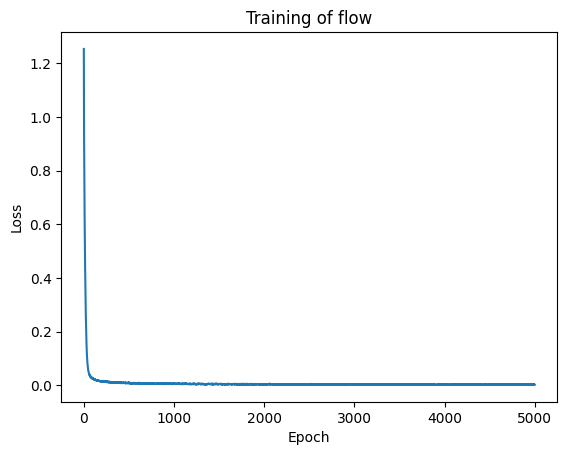

In [21]:
plt.plot(epochs_list, loss_list)
plt.title('Training of flow')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Saving files

In [22]:
# Save the last u_mean and u_std
save_path = data_dir + "normalization_stats.pt"
torch.save({
    'u_mean': u_mean,
    'u_std': u_std
}, save_path)

In [23]:
save_path = data_dir + "vf_model_weights.pt"

torch.save(vf_model.state_dict(), save_path)

In [24]:
# we want to save the best vector field:
class LearnedVectorFieldODE():
    def __init__(self, vf_model):
        self.vf_model = vf_model

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # x, z: (batch_size, latent_dim)
        # t: (batch_size, 1)
        return self.vf_model(x, z, t)

In [25]:
# Wrap the trained neural network
learned_ode = LearnedVectorFieldODE(vf_model)
save_path = data_dir + "learned_ode.pt"
# Save the wrapper
torch.save(learned_ode, save_path)